**Задание**
1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 8.2 MB 18.0 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=6bbb01f0693701d18394b6c133ec417a559d06d3bf20615a5f2b91d67e6c4b80
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.9 MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [6]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         36           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        135           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        640           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        125           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1678           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      13969           False  
house-pr

In [7]:
!kaggle datasets download -d kirillkoncha/russian-illegal-drugs-reviews-sentiment-dataset

  0% 0.00/109k [00:00<?, ?B/s]
100% 109k/109k [00:00<00:00, 31.3MB/s]


In [8]:
from string import punctuation

from pymorphy2 import MorphAnalyzer
import re
import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from stop_words import get_stop_words

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
!unzip '/content/russian-illegal-drugs-reviews-sentiment-dataset.zip'

Archive:  /content/russian-illegal-drugs-reviews-sentiment-dataset.zip
  inflating: data.csv                


In [10]:
import pandas as pd

#загрузка данных
df_train = pd.read_csv('/content/data.csv', encoding='utf-8',sep=';', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
df_train['sentiment'].value_counts()

-1    601
 1    599
Name: sentiment, dtype: int64

In [12]:
df_train['sentiment'].where(~(df_train.sentiment<0), other=0, inplace=True)

In [13]:
df_train['sentiment'].value_counts()

0    601
1    599
Name: sentiment, dtype: int64

In [14]:
df_train.head()

,content,sentiment
0,Был ненаход (клад похоронили под слоем бетона)...,1
1,"10/10/10 хорошая прогулка, за хорошим феном. Д...",1
2,"Дома,соточки по всем параметрам,спасибо всей к...",1
3,"Все супер, квест момент, Стафф как надо!",1
4,всё хорошо,1


In [15]:
train, validate, test = np.split(df_train, [int(.7*len(df_train)), int(.85*len(df_train))])

In [16]:
sw = set(get_stop_words("ru"))
puncts = set(punctuation)
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [17]:
print(sw)

{'самих', 'тринадцать', 'четырнадцать', 'будто', 'сейчас', 'к', 'всего', 'здесь', 'но', 'о', 'близко', 'более', 'каждые', 'т', 'сам', 'вдруг', 'менее', 'кругом', 'куда', 'суть', 'первый', 'должно', 'жизнь', 'время', 'несколько', 'нему', 'нередко', 'нами', 'из', 'года', 'хоть', 'кроме', 'другое', 'другая', 'одиннадцатый', 'там', 'семь', 'он', 'она', 'неё', 'другие', 'теперь', 'была', 'бывает', 'важные', 'теми', 'такой', 'может', 'восемь', 'пятый', 'низко', 'та', 'в', 'три', 'их', 'пожалуйста', 'отовсюду', 'эта', 'каждая', 'значит', 'стал', 'когда', 'оба', 'одиннадцать', 'вокруг', 'нужно', 'моя', 'под', 'даже', 'до', 'других', 'этого', 'об', 'десятый', 'тобой', 'никогда', 'над', 'почему', 'двух', 'тот', 'ж', 'был', 'везде', 'будут', 'обычно', 'недалеко', 'вас', 'слишком', 'тех', 'вами', 'будет', 'тебя', 'шесть', 'миллионов', 'многочисленное', 'бывь', 'нас', 'пятнадцать', 'один', 'чем', 'кажется', 'для', 'ведь', 'мною', 'себе', 'во', 'больше', 'ничего', 'твоя', 'вниз', 'ними', 'человек', 

In [18]:
from tqdm import tqdm 
tqdm.pandas()

train['content'] = train['content'].progress_apply(preprocess_text)
validate['content'] = validate['content'].progress_apply(preprocess_text)
test['content'] = test['content'].progress_apply(preprocess_text)

100%|██████████| 180/180 [00:01<00:00, 141.48it/s]


In [19]:
train_corpus = " ".join(train["content"])
train_corpus = train_corpus.lower()

In [20]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
tokens[:10]

['ненаход',
 'клад',
 'похоронить',
 'слой',
 'бетон',
 'максимально',
 'вежливый',
 'поддержка',
 'купончик',
 'магазин']

In [22]:
tokens_filtered = [word for word in tokens if word.isalnum()]
print(tokens_filtered)

['ненаход', 'клад', 'похоронить', 'слой', 'бетон', 'максимально', 'вежливый', 'поддержка', 'купончик', 'магазин', 'порешать', 'вопрос', '1010', '101010', 'хороший', 'прогулка', 'хороший', 'фен', 'новый', 'встреча', 'домасоточка', 'параметрамспасибо', 'весь', 'командерекомендовать', 'данный', 'шопперебрать', 'магазовдостойный', 'качество', 'тутёща', 'зайдунеотказаться', 'купонавсем', 'добро', 'супер', 'квест', 'момент', 'стаффа', 'касание', 'купить', 'забрать', 'сожрал101010', 'общий', 'видимо', 'момент', 'решить', 'сделать', 'заказ', 'попасть', 'параллельный', 'вселенная', 'чётко', 'быстро', 'восторженный', 'отзыв', 'страница', 'правда', 'передать', 'свой', 'опыт', 'отзыв', 'общий', 'очередной', 'попых', 'пытаться', 'закинуть', 'деньга', 'очередной', 'покупка', 'нерассчитать', 'комиссия', 'тд', 'итог', 'нехватать', '000002этый', '70р', 'курс', '100', 'обмен', 'гидра', 'вонючий', 'биток', '2гр', 'клад', 'наркоман', 'деньга', 'писать', 'магазин', 'просьба', 'купонить', 'сумма', 'получать

In [23]:
max_words = 20000
max_len = 10
num_classes = 1

# обучение
epochs = 10
batch_size = 512
print_batch_n = 100

In [24]:
#соберем max_words наиболее частых токенов

#частотное распределение: как часто встречается каждый токен в tokens_filtered
dist = FreqDist(tokens_filtered)
dist

FreqDist({'ненаход': 199,
          'клад': 259,
          'похоронить': 1,
          'слой': 3,
          'бетон': 1,
          'максимально': 5,
          'вежливый': 4,
          'поддержка': 10,
          'купончик': 7,
          'магазин': 252,
          'порешать': 1,
          'вопрос': 17,
          '1010': 21,
          '101010': 45,
          'хороший': 86,
          'прогулка': 7,
          'фен': 6,
          'новый': 16,
          'встреча': 22,
          'домасоточка': 1,
          'параметрамспасибо': 1,
          'весь': 6,
          'командерекомендовать': 1,
          'данный': 29,
          'шопперебрать': 1,
          'магазовдостойный': 1,
          'качество': 126,
          'тутёща': 1,
          'зайдунеотказаться': 1,
          'купонавсем': 1,
          'добро': 17,
          'супер': 17,
          'квест': 43,
          'момент': 7,
          'стаффа': 43,
          'касание': 115,
          'купить': 23,
          'забрать': 65,
          'сожрал101010': 1,


In [25]:
#берем max_words наиболее часто встречающихся токенов
#(создаем упорядоченные пары (слово, частота) в количестве max_words штук и берем первые элементы пар)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(4426,
 ['место',
  'клад',
  'магазин',
  'ненаход',
  'качество',
  'касание',
  'кладмена',
  'хороший',
  '10',
  'брать'])

In [26]:
#словарь слово : индекс из tokens_filtered_top
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top,1)).items()}
vocabulary

{'место': 1,
 'клад': 2,
 'магазин': 3,
 'ненаход': 4,
 'качество': 5,
 'касание': 6,
 'кладмена': 7,
 'хороший': 8,
 '10': 9,
 'брать': 10,
 'диспут': 11,
 'небыть': 12,
 'найти': 13,
 'забрать': 14,
 'фото': 15,
 'покупка': 16,
 'проблема': 17,
 '3': 18,
 'деньга': 19,
 'стафа': 20,
 '101010': 21,
 'вес': 22,
 '2': 23,
 'сделать': 24,
 'товар': 25,
 'квест': 26,
 'стаффа': 27,
 'ребята': 28,
 'курьер': 29,
 'такой': 30,
 'ненайти': 31,
 'описание': 32,
 'купон': 33,
 'лес': 34,
 'сразу': 35,
 'снять': 36,
 'решить': 37,
 'чётко': 38,
 'быстро': 39,
 'один': 40,
 'взять': 41,
 'думать': 42,
 'отзыв': 43,
 'итог': 44,
 'вообще': 45,
 'прийтись': 46,
 'респект': 47,
 'перезаклад': 48,
 'данный': 49,
 'час': 50,
 'дать': 51,
 'поднять': 52,
 'км': 53,
 'магаз': 54,
 'самый': 55,
 'несоветовать': 56,
 'хотеть': 57,
 'искать': 58,
 'магаза': 59,
 'норма': 60,
 'работа': 61,
 'координата': 62,
 'топ': 63,
 'предложить': 64,
 'делать': 65,
 'марка': 66,
 'друг': 67,
 'купить': 68,
 'сюда': 6

In [27]:
#преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] #фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) #если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) #нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [28]:

x_train = np.asarray([text_to_sequence(text, max_len) for text in train["content"]], dtype=np.int32)
x_valid = np.asarray([text_to_sequence(text, max_len) for text in validate["content"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in test["content"]], dtype=np.int32)

x_train.shape, x_valid.shape, x_test.shape

((840, 10), (180, 10), (180, 10))

In [29]:
#данные после подготовки к обучению
torch.from_numpy(x_train[0])

tensor([ 699, 1557,  471,  562,  234,  345,    3, 1558,  115,   82],
       dtype=torch.int32)

In [30]:
x_train[1]

array([ 21,   8, 346,   8, 394, 127,  73,   0,   0,   0], dtype=int32)

In [31]:
from torch.utils.data import DataLoader, Dataset
import torch


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [32]:
df_train

,content,sentiment
0,Был ненаход (клад похоронили под слоем бетона)...,1
1,"10/10/10 хорошая прогулка, за хорошим феном. Д...",1
2,"Дома,соточки по всем параметрам,спасибо всей к...",1
3,"Все супер, квест момент, Стафф как надо!",1
4,всё хорошо,1
...,...,...
1195,"Не наход. Магазин сказал ждём минёра, тот так ...",0
1196,НИ ОДНОГО НАХОДА. 3 РАЗА ВСЕ МИМО. оно и неуди...,0
1197,"Ненаход, в неочень долгом диспуте магазин и кл...",0
1198,"Пиздец!!! Это мало говоря. Канавинский р-он, з...",0


In [33]:
train_dataset = DataWrapper(x_train, train['sentiment'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_valid, validate['sentiment'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [34]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 10]) tensor([  55,  837, 2418,  123,  133,  133, 2419,   11,   71,   12])
torch.Size([512]) tensor(0)


In [35]:
#LSTM
class LSTMFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        lstm_out, ht = self.lstm(x) 
        # lstm_out: тензор с выходными фичами с последнего слоя для каждого t #(B, L, Hout)
        # h_t: тензор с последними скрытыми состояниями по слоям  #(num_layers, B, Hout)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]  #(B, Hout) тензор с последней строкой из каждого батча
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)  #(B, Hout) тензор со средним арифметическим столбцов по каждому батчу
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [36]:
#инициализация модели
model_lstm = LSTMFixedLen(max_words, 128, 128, use_last=False)
print(model_lstm)
print("Parameters:", sum([param.nelement() for param in model_lstm.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(20000, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 2824321


In [37]:
#компиляция модели
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [38]:
import torchmetrics

In [39]:
%%time

#обучение модели
model_lstm.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_lstm = []
valid_acc_history_lstm = []

train_acc = torchmetrics.Accuracy()
test_acc = torchmetrics.Accuracy()

for epoch in range(epochs):  
    model_lstm.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_lstm.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_lstm.append(train_acc.compute().item())
    train_acc.reset()

    
    # выводим статистику на тестовых данных
    for j, data in enumerate(val_loader):
        test_labels = data[1]
        test_outputs = model_lstm(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)

    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_lstm.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')

Epoch [1/10]. Step [2/2]. Loss: 0.694. Acc: 0.524. Test loss: 0.704. Test acc: 0.361
Epoch [2/10]. Step [2/2]. Loss: 0.686. Acc: 0.524. Test loss: 0.697. Test acc: 0.367
Epoch [3/10]. Step [2/2]. Loss: 0.680. Acc: 0.538. Test loss: 0.686. Test acc: 0.544
Epoch [4/10]. Step [2/2]. Loss: 0.672. Acc: 0.625. Test loss: 0.668. Test acc: 0.633
Epoch [5/10]. Step [2/2]. Loss: 0.653. Acc: 0.699. Test loss: 0.640. Test acc: 0.706
Epoch [6/10]. Step [2/2]. Loss: 0.612. Acc: 0.732. Test loss: 0.598. Test acc: 0.733
Epoch [7/10]. Step [2/2]. Loss: 0.575. Acc: 0.758. Test loss: 0.546. Test acc: 0.733
Epoch [8/10]. Step [2/2]. Loss: 0.537. Acc: 0.765. Test loss: 0.500. Test acc: 0.761
Epoch [9/10]. Step [2/2]. Loss: 0.471. Acc: 0.783. Test loss: 0.473. Test acc: 0.783
Epoch [10/10]. Step [2/2]. Loss: 0.509. Acc: 0.786. Test loss: 0.465. Test acc: 0.783
Training is finished!
CPU times: user 4.47 s, sys: 150 ms, total: 4.62 s
Wall time: 4.75 s


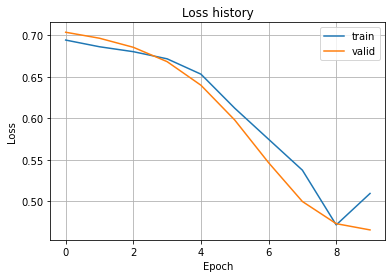

In [40]:
#визуализации функции потерь
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

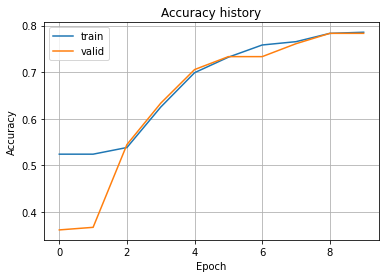

In [41]:
#визуализации метрики
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history_lstm, label='train')
plt.plot(valid_acc_history_lstm, label='valid')
plt.legend()

In [42]:
#GRU
class GRUFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)

        gru_out, ht = self.gru(x) 
        # gru_out: тензор с выходными фичами с последнего слоя для каждого t #(B, L, Hout)
        # h_t: тензор с последними скрытыми состояниями по слоям  #(num_layers, B, Hout)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]  #(B, Hout) тензор с последней строкой из каждого батча
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)  #(B, Hout) тензор со средним арифметическим столбцов по каждому батчу
    
        out = self.linear(last_tensor)
        
        return torch.sigmoid(out)

In [43]:
#инициализация модели
model_gru = GRUFixedLen(max_words, 128, 128, use_last=False)
print(model_gru)
print("Parameters:", sum([param.nelement() for param in model_gru.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(20000, 128, padding_idx=0)
  (gru): GRU(128, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 2758273


In [44]:
#компиляция модели
optimizer = torch.optim.Adam(model_gru.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [45]:
%%time

#обучение модели
model_gru.train()

train_loss_history = []
valid_loss_history = []

train_acc_history_gru = []
valid_acc_history_gru = []

train_acc = torchmetrics.Accuracy()
test_acc = torchmetrics.Accuracy()

for epoch in range(epochs):  
    model_gru.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model_gru(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        
        # подсчет метрики на обучении
        train_acc(outputs.squeeze(), labels)
        
    # выводим статистику о процессе обучения
    model_gru.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {train_acc.compute().item():.3f}', end='. ')

    train_loss_history.append(loss)
    train_acc_history_gru.append(train_acc.compute().item())
    train_acc.reset()
    

    # выводим статистику на тестовых данных

    for j, data in enumerate(val_loader):
        test_labels = data[1]
        test_outputs = model_gru(data[0])
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        
        # подсчет метрики на тесте
        test_acc(test_outputs.squeeze(), test_labels)
    
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_acc.compute().item():.3f}')
    valid_loss_history.append(test_loss.item())
    valid_acc_history_gru.append(test_acc.compute().item())
    test_acc.reset()
    
print('Training is finished!')

Epoch [1/10]. Step [2/2]. Loss: 0.690. Acc: 0.507. Test loss: 0.691. Test acc: 0.489
Epoch [2/10]. Step [2/2]. Loss: 0.681. Acc: 0.615. Test loss: 0.682. Test acc: 0.606
Epoch [3/10]. Step [2/2]. Loss: 0.666. Acc: 0.700. Test loss: 0.667. Test acc: 0.656
Epoch [4/10]. Step [2/2]. Loss: 0.638. Acc: 0.708. Test loss: 0.645. Test acc: 0.678
Epoch [5/10]. Step [2/2]. Loss: 0.611. Acc: 0.727. Test loss: 0.611. Test acc: 0.694
Epoch [6/10]. Step [2/2]. Loss: 0.574. Acc: 0.770. Test loss: 0.571. Test acc: 0.711
Epoch [7/10]. Step [2/2]. Loss: 0.537. Acc: 0.769. Test loss: 0.536. Test acc: 0.711
Epoch [8/10]. Step [2/2]. Loss: 0.482. Acc: 0.764. Test loss: 0.527. Test acc: 0.733
Epoch [9/10]. Step [2/2]. Loss: 0.450. Acc: 0.800. Test loss: 0.544. Test acc: 0.733
Epoch [10/10]. Step [2/2]. Loss: 0.427. Acc: 0.796. Test loss: 0.559. Test acc: 0.733
Training is finished!
CPU times: user 4.01 s, sys: 74.5 ms, total: 4.09 s
Wall time: 4.23 s


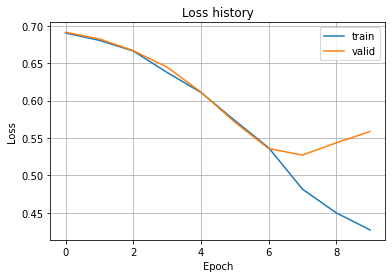

In [46]:
#визуализации функции потерь
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

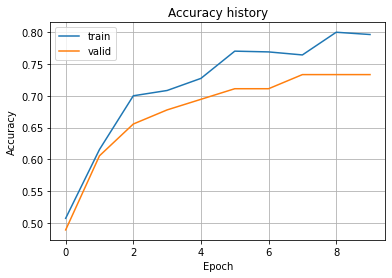

In [47]:
#визуализации метрики
plt.title('Accuracy history')
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history_gru, label='train')
plt.plot(valid_acc_history_gru, label='valid')
plt.legend()